In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [ ]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Importing Data 

In [ ]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# Preprocessing

**Crema DataFrame**

CREMA-D là một tập dữ liệu gồm 7.442 đoạn clip gốc từ 91 diễn viên. Các đoạn clip này được thực hiện bởi 48 diễn viên nam và 43 diễn viên nữ, trong độ tuổi từ 20 đến 74, thuộc nhiều chủng tộc và sắc tộc khác nhau (gồm người gốc Phi, châu Á, da trắng, người gốc Tây Ban Nha và không xác định). Các diễn viên phát âm từ một tập hợp gồm 12 câu. Những câu này được thể hiện với một trong sáu trạng thái cảm xúc khác nhau (Giận dữ, Ghê tởm, Sợ hãi, Vui vẻ, Bình thản và Buồn bã) và ở bốn cấp độ cảm xúc khác nhau (Thấp, Trung bình, Cao và Không xác định).

In [ ]:
# Liệt kê tất cả các tệp trong thư mục
crema_directory_list = os.listdir(Crema)

# Khởi tạo danh sách lưu cảm xúc và đường dẫn tệp
file_emotion = []
file_path = []

# Ánh xạ nhãn cảm xúc
emotion_map = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SUR': 'surprise'  # Giả định 'SUR' là nhãn cho cảm xúc ngạc nhiên
}

for file in crema_directory_list:
    # Lưu đường dẫn của tệp
    file_path.append(os.path.join(Crema, file))
    # Trích xuất nhãn cảm xúc từ tên tệp
    part = file.split('_')
    emotion = emotion_map.get(part[2], 'Unknown')
    file_emotion.append(emotion)

# Tạo DataFrame chứa cảm xúc
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Tạo DataFrame chứa đường dẫn
path_df = pd.DataFrame(file_path, columns=['Path'])

# Kết hợp hai DataFrame
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Hiển thị các hàng đầu tiên
print(Crema_df.head())

# Đếm số lượng mỗi loại cảm xúc
print(Crema_df.Emotions.value_counts())

**TESS dataset**

Có một tập hợp gồm 200 từ mục tiêu được phát âm trong cụm từ mẫu "Say the word _" bởi hai nữ diễn viên (26 và 64 tuổi). Các bản ghi âm của tập hợp này được thực hiện với bảy trạng thái cảm xúc khác nhau (giận dữ, ghê tởm, sợ hãi, hạnh phúc, ngạc nhiên, buồn bã và trung lập). Tổng cộng có 2800 điểm dữ liệu (tệp âm thanh).

Tập dữ liệu được tổ chức sao cho mỗi diễn viên nữ và các cảm xúc của họ được chứa trong một thư mục riêng. Bên trong thư mục đó, có thể tìm thấy tất cả 200 tệp âm thanh của các từ mục tiêu. Định dạng của tệp âm thanh là WAV.

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        parts = file.split('.')[0].split('_')
        if len(parts) < 3:
            continue
        part = parts[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# Tạo DataFrame cho cảm xúc và đường dẫn:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

**SAVEE Dataset**

**Ngữ cảnh**

Cơ sở dữ liệu SAVEE được thu âm từ bốn người đàn ông bản xứ nói tiếng Anh (được nhận diện là DC, JE, JK, KL), là sinh viên sau đại học và nhà nghiên cứu tại Đại học Surrey, trong độ tuổi từ 27 đến 31. Cảm xúc được mô tả theo các danh mục tâm lý riêng biệt: giận dữ, ghê tởm, sợ hãi, hạnh phúc, buồn bã và ngạc nhiên. Chúng tôi đã thêm cảm xúc trung lập để cung cấp các bản ghi âm của 7 loại cảm xúc. Nội dung văn bản bao gồm 15 câu từ tập TIMIT cho mỗi cảm xúc: 3 câu chung, 2 câu đặc trưng cho cảm xúc và 10 câu chung chung khác nhau cho từng cảm xúc và được cân bằng về mặt ngữ âm. Ba câu chung và 2 × 6 = 12 câu đặc trưng cảm xúc được ghi âm dưới dạng trung lập để tạo thành 30 câu trung lập.

Nội dung
Điều này dẫn đến tổng cộng 120 câu nói cho mỗi người nói, ví dụ:

- Common: She had your dark suit in greasy wash water all year.
- Anger: Who authorized the unlimited expense account?
- Disgust: Please take this dirty table cloth to the cleaners for me.
- Fear: Call an ambulance for medical assistance.
- Happiness: Those musicians harmonize marvelously.
- Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
- Surprise: The carpet cleaners shampooed our oriental rug.
- Neutral: The best way to learn is to solve extra problems.

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

# Ánh xạ nhãn cảm xúc
emotion_map = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'  # Giả định 'su' là nhãn cho cảm xúc ngạc nhiên
}

for file in savee_directory_list:
    file_path.append(os.path.join(Savee, file))
    part = file.split('_')[1]
    ele = part[:-6]
    emotion = emotion_map.get(ele, 'Unknown')
    file_emotion.append(emotion)

# Tạo DataFrame chứa cảm xúc
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Tạo DataFrame đường dẫn
path_df = pd.DataFrame(file_path, columns=['Path'])

# Kết hợp hai DataFrame
Savee_df = pd.concat([emotion_df, path_df], axis=1)

print(Savee_df.head())

print(Savee_df.Emotions.value_counts())

# **Integration**

In [ ]:
# Tạo Dataframe bằng cách sử dụng tất cả 3 dataframe mà chúng tôi đã tạo cho đến nay.
data_path = pd.concat([Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern style for the plot
sns.set_theme(style="whitegrid", palette="pastel")

# Create a larger figure for better visibility
plt.figure(figsize=(10, 6))
plt.title('Distribution of Emotions', fontsize=18, fontweight='bold', color='#333')

# Plot the countplot with more customization
ax = sns.countplot(
    data=data_path, 
    x='Emotions', 
    palette='coolwarm', 
    order=data_path.Emotions.value_counts().index  # Order by frequency
)

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}", 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='baseline', 
        fontsize=12, 
        color='black', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

# Customize labels
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xlabel('Emotions', fontsize=14, labelpad=10)

# Remove unnecessary spines for a cleaner look
sns.despine()

# Add a subtle grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the value counts for reference
print(data_path.Emotions.value_counts())

In [ ]:
data,sr = librosa.load(file_path[0])
sr

- data: Mảng chứa tín hiệu âm thanh (dạng numpy array).
- sr: Tần số lấy mẫu của âm thanh (mặc định 22050 Hz nếu không chỉ định khác).

In [ ]:
# In cái file path đầu tiên
print(file_path[0])

In [ ]:
# Phát đoạn âm thanh data với tần số lấy mẫu sr
ipd.Audio(data,rate=sr)

- ipd.Audio: Hàm từ IPython.display dùng để phát âm thanh trong Jupyter Notebook.
- data: Mảng chứa tín hiệu âm thanh.
- rate=sr: Tần số lấy mẫu (sampling rate) của âm thanh.

In [ ]:
# Hiển thị một Mel spectrogram của âm thanh với tần số và cường độ (dB) ở mỗi thời điểm.
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

In [ ]:
# Tính toán MFCC từ tín hiệu âm thanh data với tần số lấy mẫu sr.
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    # Ensure the audio is 1D
    if data.ndim > 1:
        data = data.flatten()
    return librosa.effects.time_stretch(data, rate = rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y =data, sr = sampling_rate, n_steps = pitch_factor)

**noise(data):**

- Mục đích: Thêm nhiễu ngẫu nhiên vào dữ liệu âm thanh.
- Cách hoạt động:
    Tạo một giá trị nhiễu ngẫu nhiên (noise_amp) theo tỷ lệ phần trăm với giá trị tối đa của âm thanh (np.amax(data)).
    Thêm nhiễu vào dữ liệu âm thanh ban đầu bằng cách cộng thêm nhiễu Gaussian được tạo ra bởi np.random.normal().
  
**stretch(data, rate=0.8):**

- Mục đích: Thực hiện thay đổi tốc độ (thời gian kéo dài hoặc rút ngắn) của âm thanh mà không thay đổi cao độ.
- Cách hoạt động:
    Nếu dữ liệu âm thanh có nhiều hơn một chiều (âm thanh stereo), nó sẽ chuyển thành một mảng 1D bằng cách gọi flatten().
    Sử dụng librosa.effects.time_stretch() để thay đổi thời gian âm thanh theo tỉ lệ rate.
  
**shift(data):**

- Mục đích: Dịch chuyển tín hiệu âm thanh theo thời gian.
- Cách hoạt động:
    Tạo một giá trị dịch chuyển ngẫu nhiên (shift_range) trong khoảng từ -5000 đến 5000 mẫu.
    Dịch chuyển mảng dữ liệu âm thanh sử dụng np.roll(), giúp làm thay đổi vị trí của các mẫu âm thanh.
  
**pitch(data, sampling_rate, pitch_factor=0.7):**

- Mục đích: Thay đổi cao độ (pitch) của âm thanh.
- Cách hoạt động:
    Sử dụng librosa.effects.pitch_shift() để thay đổi cao độ âm thanh.
    n_steps được xác định bởi pitch_factor, điều chỉnh cao độ theo tỷ lệ (giảm hoặc tăng cao độ).

In [ ]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


**zcr(data, frame_length, hop_length)**

- Tính toán Zero Crossing Rate (ZCR), là số lần tín hiệu âm thanh thay đổi dấu trong một khung (frame).
- frame_length: Kích thước khung (số mẫu trong mỗi khung).
- hop_length: Bước nhảy giữa các khung.
- Kết quả trả về là một mảng 1D của ZCR cho mỗi khung âm thanh.

**rmse(data, frame_length=2048, hop_length=512)**

- Tính toán Root Mean Square Error (RMSE), đo độ lớn của tín hiệu âm thanh.
- frame_length và hop_length: Tương tự như trong hàm ZCR, chỉ định kích thước khung và bước nhảy.

**mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True)**

- Tính toán MFCC (Mel-frequency cepstral coefficients), một đặc trưng quan trọng trong phân tích âm thanh, đặc biệt trong nhận diện giọng nói.
- flatten: Nếu True, kết quả sẽ được chuyển thành mảng 1D (sử dụng np.ravel()), nếu không sẽ giữ dạng 2D.

**extract_features(data, sr=22050, frame_length=2048, hop_length=512)**

- Trích xuất các đặc trưng từ tín hiệu âm thanh data.
- Kết hợp các đặc trưng: ZCR, RMSE và MFCC bằng cách sử dụng hàm hstack (kết hợp các mảng theo chiều ngang).

**get_features(path, duration=2.5, offset=0.6)**

- Đọc tệp âm thanh từ path với độ dài duration và độ trễ offset.
- Trích xuất các đặc trưng từ âm thanh gốc và các biến thể của nó (âm thanh có nhiễu, thay đổi cao độ, và âm thanh có nhiễu với thay đổi cao độ).
- Kết quả là một mảng 2D chứa tất cả các đặc trưng trích xuất được từ âm thanh gốc và các biến thể.

# Get features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer() #Ghi lại thời gian bắt đầu
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

**for path, emotion, index in tqdm(zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0]))):**:
- Duyệt qua từng tệp âm thanh trong data_path.Path và các nhãn cảm xúc tương ứng trong data_path.Emotions.
- zip() kết hợp các giá trị từ ba danh sách (đường dẫn tệp, nhãn cảm xúc và chỉ số).
- tqdm(): Hiển thị thanh tiến độ cho vòng lặp.

**features = get_features(path)**: Trích xuất đặc trưng âm thanh từ tệp tại path.
**if index % 500 == 0:**: Mỗi khi xử lý xong 500 tệp, in ra thông báo để theo dõi tiến độ.
**X.append(i)** và **Y.append(emotion)**:
- Lưu trữ đặc trưng i và nhãn cảm xúc emotion vào các danh sách X và Y tương ứng.

In [ ]:
len(X), len(Y), data_path.Path.shape


# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

In [2]:
Emotions = pd.read_csv('/kaggle/input/emotion/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.238770,0.361816,0.478516,0.473633,0.485352,0.476074,0.472656,0.468262,0.472656,0.486816,...,2.192987,1.378691,1.542983,1.766679,-1.586487,-0.501919,-3.159530,-5.015890,-0.942531,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518931,0.839123,1.308965,1.855116,2.404975,2.896071,3.282977,3.541091,3.666846,surprise
3,0.252930,0.382812,0.497559,0.497070,0.487793,0.472656,0.482422,0.484375,0.497070,0.510254,...,-2.445378,-2.712779,-1.120462,-3.266942,7.691891,7.443986,-2.031003,-2.095720,-1.418903,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585884,2.746578,2.223155,0.986784,-0.730886,-2.531058,-4.002848,-4.849192,-4.929412,neutral


In [3]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [4]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [5]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [6]:
#lấy tất cả các hàng và tất cả các cột trừ cột cuối cùng cho X bao gồm các tính năng
#lấy cột cuối cùng cho Y, bao gồm cả cảm xúc
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [7]:
# Chuyển đổi nhãn Y thành dạng mã hóa một nóng, phù hợp với bài toán phân loại nhiều lớp (multiclass classification).
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

One-Hot Encoding biến các nhãn phân loại thành các vector, trong đó mỗi lớp sẽ có một vị trí "1" duy nhất, còn lại là "0".
Ví dụ:

Nếu nhãn Y = ['happy', 'sad', 'angry', 'happy'], thì sau khi One-Hot Encoding, Y sẽ trở thành:

[[0, 1, 0],   # happy

 [1, 0, 0],   # sad
 
 [0, 0, 1],   # angry
 
 [0, 1, 0]]   # happy

 **Tóm tắt**: Đoạn mã này biến đổi nhãn Y thành dạng One-Hot Encoding để có thể sử dụng cho các mô hình phân loại đa lớp (multiclass classification).

In [8]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [10]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [11]:
# Chuẩn hóa dữ liệu bằng cách sử dụng StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

- StandardScaler chuẩn hóa dữ liệu của bạn sao cho mỗi tính năng có trung bình bằng 0 và độ lệch chuẩn bằng 1.
- fit_transform() được sử dụng trên dữ liệu huấn luyện để tính toán tham số chuẩn hóa, trong khi transform() chỉ áp dụng chuẩn hóa cho dữ liệu kiểm tra.

In [12]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for models


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

- **ModelCheckpoint** là một callback lưu lại trọng số của mô hình trong quá trình huấn luyện, chỉ lưu lại mô hình có độ chính xác (accuracy) trên tập kiểm tra (val_accuracy) tốt nhất.
- **monitor='val_accuracy'**: Theo dõi độ chính xác trên tập kiểm tra.
- **save_best_only=True**: Chỉ lưu trọng số mô hình khi đạt được độ chính xác tốt nhất trên tập kiểm tra.
- **'best_model1_weights.keras'**: Tên tệp nơi trọng số của mô hình sẽ được lưu.
**Ý nghĩa**: Callback này giúp bạn lưu lại mô hình với trọng số tốt nhất trong quá trình huấn luyện.

In [14]:

early_stop=EarlyStopping(monitor='val_acc',mode='max',patience=3,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

**EarlyStopping**:

- **EarlyStopping** là một callback dừng huấn luyện sớm nếu mô hình không cải thiện sau một số epoch nhất định. Điều này giúp tránh overfitting.
- **monitor='val_acc'**: Theo dõi độ chính xác trên tập kiểm tra (val_acc).
- **mode='max'**: Dừng khi giá trị val_acc không còn tăng nữa (tức là không cải thiện nữa).
- **patience=3**: Nếu mô hình không cải thiện trong 3 epoch liên tiếp, quá trình huấn luyện sẽ dừng lại.
- **restore_best_weights=True**: Khi dừng sớm, trọng số của mô hình sẽ được khôi phục lại từ epoch có độ chính xác tốt nhất.
  
**Ý nghĩa**: Callback này giúp dừng huấn luyện sớm để tránh overfitting và khôi phục lại trọng số của mô hình từ thời điểm tốt nhất.

**ReduceLROnPlateau:**

- **ReduceLROnPlateau** giảm tốc độ học (learning rate) nếu mô hình không cải thiện sau một số epoch nhất định.
- **monitor='val_acc'**: Theo dõi độ chính xác trên tập kiểm tra (val_acc).
- **patience=3**: Nếu mô hình không cải thiện trong 3 epoch liên tiếp, tốc độ học sẽ được giảm.
- **verbose=1**: Hiển thị thông báo khi tốc độ học bị giảm.
- **factor=0.5**: Giảm tốc độ học xuống một nửa khi không có sự cải thiện.
- **min_lr=0.00001**: Đảm bảo rằng tốc độ học không giảm xuống dưới giá trị này.
  
**Ý nghĩa**: Callback này giúp giảm tốc độ học nếu mô hình không cải thiện, giúp tìm ra tốc độ học tốt hơn và tránh việc huấn luyện với tốc độ học quá lớn.

# LSTM Model

In [15]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(BatchNormalization())
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(BatchNormalization())
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(BatchNormalization())
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(BatchNormalization())
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(BatchNormalization())
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.3))
model01.add(BatchNormalization())
model01.add(LSTM(128))
model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2376, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2376, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 860,039 (3.28 MB)

 Trainable params: 858,503 (3.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [16]:
hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=128,
            verbose=1,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.1696 - loss: 1.9291 - val_accuracy: 0.1949 - val_loss: 1.9018 - learning_rate: 0.0010
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.1779 - loss: 1.8971 - val_accuracy: 0.1924 - val_loss: 1.8941 - learning_rate: 0.0010
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.1742 - loss: 1.8885 - val_accuracy: 0.2005 - val_loss: 1.8845 - learning_rate: 0.0010
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.1857 - loss: 1.8810 - val_accuracy: 0.1873 - val_loss: 1.8468 - learning_rate: 0.0010
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.2159 - loss: 1.8268 - val_accuracy: 0.2268 - val_loss: 1.8705 - learning_rate: 0.0010
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.1830 - loss: 1.8964 - val_accuracy: 0.1745 - val_loss: 1.9523 - learning_rate: 0.0010
Epoch 7/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.2379 - loss: 1.

305/305 ━━━━━━━━━━━━━━━━━━━━ 115s 377ms/step - accuracy: 0.5251 - loss: 1.2119
Accuracy of our model on test data :  52.5282621383667 %


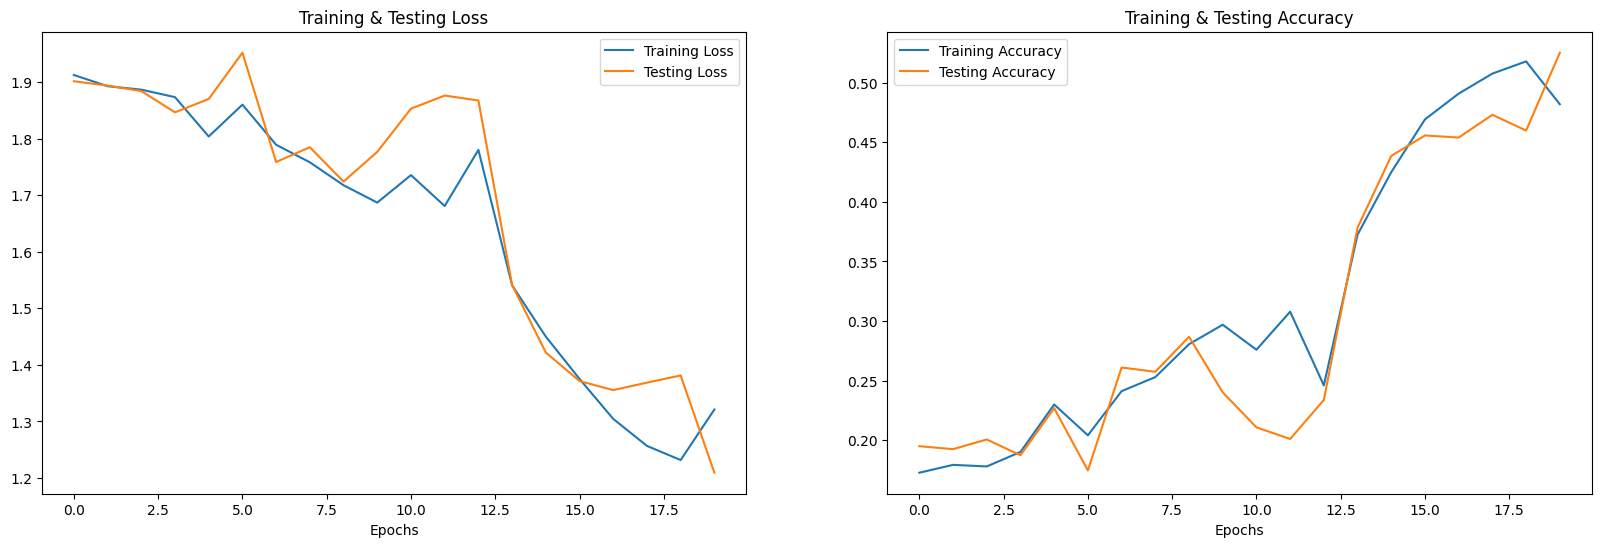

In [17]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# predicting on test data.
pred_test = model01.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred.flatten()
df0['Actual Labels'] = y_test.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 114s 372ms/step


,Predicted Labels,Actual Labels
0,surprise,angry
1,disgust,angry
2,sad,disgust
3,happy,happy
4,neutral,fear
5,fear,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


# Evalutation

Results of best model

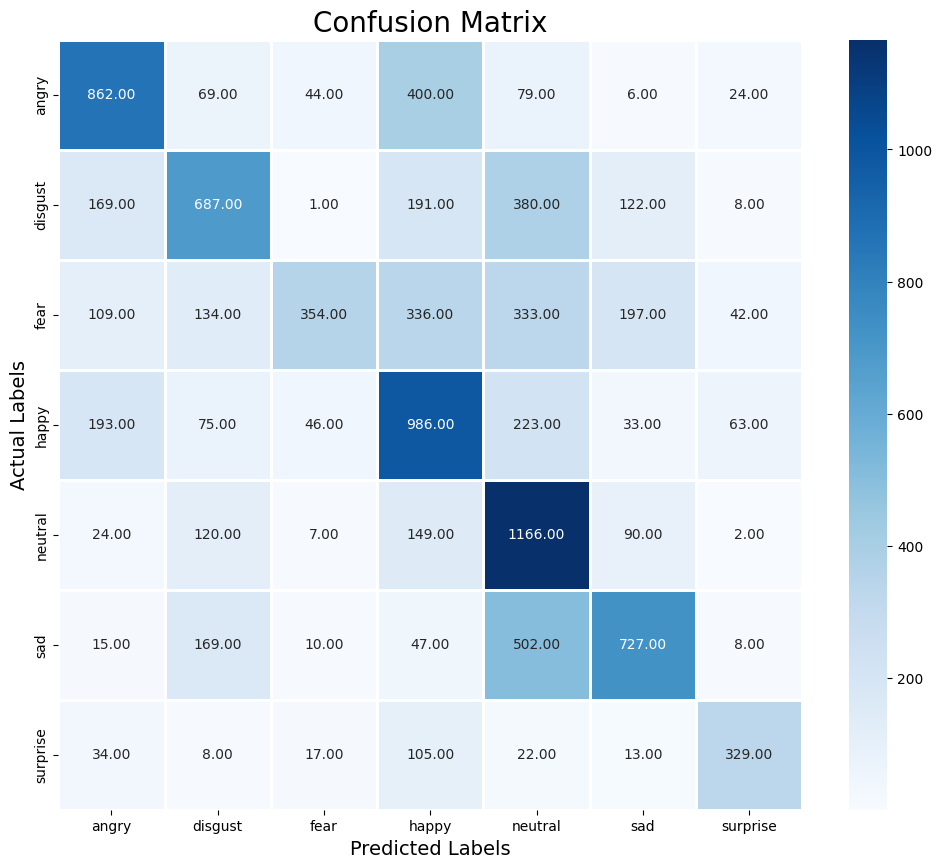

              precision    recall  f1-score   support

       angry       0.61      0.58      0.60      1484
     disgust       0.54      0.44      0.49      1558
        fear       0.74      0.24      0.36      1505
       happy       0.45      0.61      0.51      1619
     neutral       0.43      0.75      0.55      1558
         sad       0.61      0.49      0.55      1478
    surprise       0.69      0.62      0.66       528

    accuracy                           0.53      9730
   macro avg       0.58      0.53      0.53      9730
weighted avg       0.57      0.53      0.52      9730



In [34]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

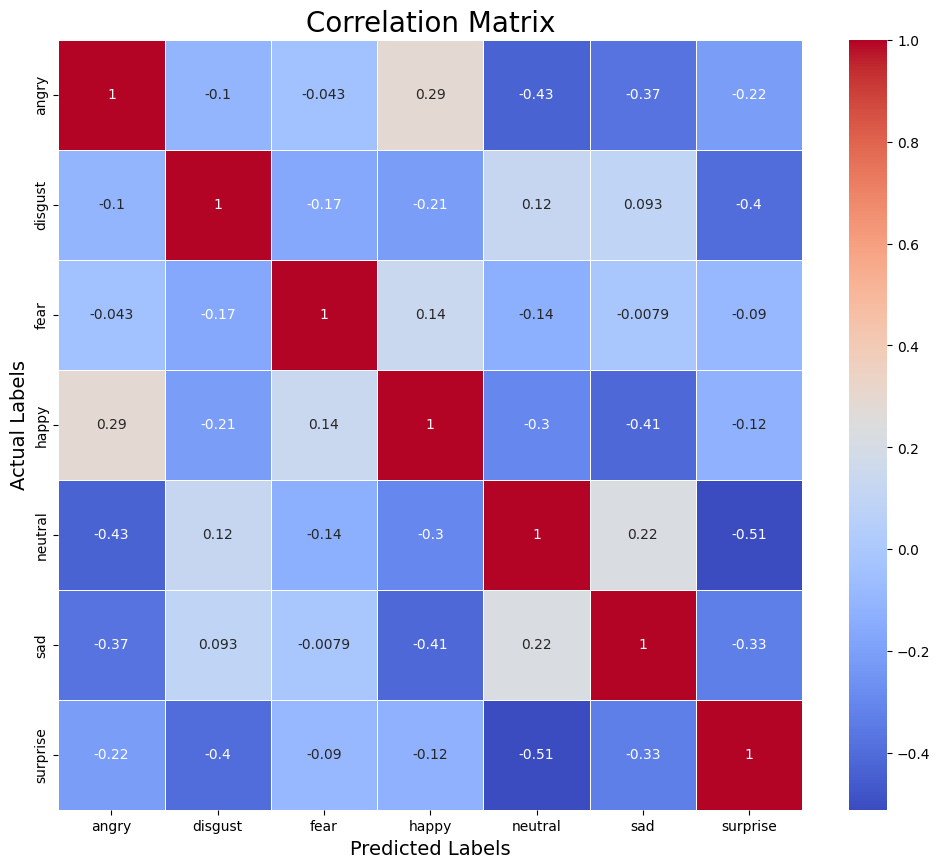

In [36]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])

# Compute the correlation matrix
correlation_matrix = cm_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Saving Best Model

In [41]:
from tensorflow.keras.models import Sequential, model_from_json

# Serialize model to JSON
model_json = model01.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model01.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk
